# 빅쿼리 연결

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
## 라이브러리 로드

# BigQuery
from google.cloud import bigquery

# viz libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.express as px

# viz settings
%matplotlib inline
sns.set()
init_notebook_mode(connected=True)

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 45.0 MB/s eta 0:00:00


In [ ]:
# Client 객체 생성
client = bigquery.Client(project = '755804531278')

# 데이터셋 참조경로(reference) 설정
# Kaggle커널에서는 bq_helper를 대신 사용할 수도 있다.
dataset_ref = client.dataset('google_analytics_sample', project='bigquery-public-data')

# 해당 경로로부터 데이터셋 추출
dataset = client.get_dataset(dataset_ref)

In [ ]:
# 데이터셋을 테이블 단위로 보기
tables = list(client.list_tables(dataset))
table_names = sorted([t.table_id for t in tables])

# 테이블 단위로 간단한 정보 확인
print(f"""table 개수 : {len(tables)}
tables : {", ".join(table_names[:3])}, ...
date 범위 : {table_names[0][-8:]} ~ {table_names[-1][-8:]}""")

table 개수 : 369
tables : Google-ecommerce-dataset-table, daily_total_visits, daily_visits, ...
date 범위 : et-table ~ 20170801


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
# 테이블 경로 생성
table_ref_temp = dataset_ref.table(table_names[0])

# 테이블 가져오기
table_temp = client.get_table(table_ref_temp)

# 컬럼 확인
client.list_rows(table_temp, max_results=5).to_dataframe()

""


#1. 코호트 분석
- 사용자의 최초 방문 월을 기준으로 그룹을 나누고, 각 Cohort가 이후 몇 개월 뒤에도 얼마나 재방문하는지를 추적해 유지율 분석하는 방법
- first_visits CTE
  - 사용자(fullVisitorId)별 최초 방문일을 계산하고, yyyy-mm 형태의 첫 방문 Cohort 월 생성
- sessions_with_cohore CTE
  - 각 세션을 해당 사용자의 Cohort 월과 조인
  - session_month를 계산하고, 최초 방문 Cohort 월로부터 몇 개월이 지났는지(months_since_first_visit)를 구함
- 최종 SELECT
  - Cohort 월별로 최초 사용자 수(users_in_cohort)와 Cohort 이후 N개월 차에 재방문한 사용자 수(month_n_retained_users)를 계산

In [ ]:
query = f"""
WITH first_visits AS (
  SELECT
    fullVisitorId,
    FORMAT_DATE('%Y-%m', MIN(PARSE_DATE('%Y%m%d', _TABLE_SUFFIX))) AS first_visit_month
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  GROUP BY
    fullVisitorId
),

sessions_with_cohort AS (
  SELECT
    s.fullVisitorId,
    f.first_visit_month,
    FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX)) AS session_month,
    DATE_DIFF(
      DATE_TRUNC(PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX), MONTH),
      DATE_TRUNC(DATE(CONCAT(f.first_visit_month, '-01')), MONTH),
      MONTH) AS months_since_first_visit
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` s
  JOIN
    first_visits f
  ON
    s.fullVisitorId = f.fullVisitorId
  WHERE
    s._TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
)

SELECT
  first_visit_month AS cohort_month,
  COUNT(DISTINCT CASE WHEN months_since_first_visit = 0 THEN fullVisitorId END) AS users_in_cohort,

  COUNT(DISTINCT CASE WHEN months_since_first_visit = 1 THEN fullVisitorId END) AS month_1_retained_users,
  COUNT(DISTINCT CASE WHEN months_since_first_visit = 2 THEN fullVisitorId END) AS month_2_retained_users,
  COUNT(DISTINCT CASE WHEN months_since_first_visit = 3 THEN fullVisitorId END) AS month_3_retained_users,
  COUNT(DISTINCT CASE WHEN months_since_first_visit = 4 THEN fullVisitorId END) AS month_4_retained_users,
  COUNT(DISTINCT CASE WHEN months_since_first_visit = 5 THEN fullVisitorId END) AS month_5_retained_users,
  COUNT(DISTINCT CASE WHEN months_since_first_visit = 6 THEN fullVisitorId END) AS month_6_retained_users,
  COUNT(DISTINCT CASE WHEN months_since_first_visit = 7 THEN fullVisitorId END) AS month_7_retained_users,
  COUNT(DISTINCT CASE WHEN months_since_first_visit = 8 THEN fullVisitorId END) AS month_8_retained_users,
  COUNT(DISTINCT CASE WHEN months_since_first_visit = 9 THEN fullVisitorId END) AS month_9_retained_users,
  COUNT(DISTINCT CASE WHEN months_since_first_visit = 10 THEN fullVisitorId END) AS month_10_retained_users,
  COUNT(DISTINCT CASE WHEN months_since_first_visit = 11 THEN fullVisitorId END) AS month_11_retained_users,
  COUNT(DISTINCT CASE WHEN months_since_first_visit = 12 THEN fullVisitorId END) AS month_12_retained_users,

  SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN months_since_first_visit = 1 THEN fullVisitorId END),
              COUNT(DISTINCT CASE WHEN months_since_first_visit = 0 THEN fullVisitorId END)) AS month_1_retention_rate,
  SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN months_since_first_visit = 2 THEN fullVisitorId END),
              COUNT(DISTINCT CASE WHEN months_since_first_visit = 0 THEN fullVisitorId END)) AS month_2_retention_rate,
  SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN months_since_first_visit = 3 THEN fullVisitorId END),
              COUNT(DISTINCT CASE WHEN months_since_first_visit = 0 THEN fullVisitorId END)) AS month_3_retention_rate,
  SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN months_since_first_visit = 4 THEN fullVisitorId END),
              COUNT(DISTINCT CASE WHEN months_since_first_visit = 0 THEN fullVisitorId END)) AS month_4_retention_rate,
  SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN months_since_first_visit = 5 THEN fullVisitorId END),
              COUNT(DISTINCT CASE WHEN months_since_first_visit = 0 THEN fullVisitorId END)) AS month_5_retention_rate,
  SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN months_since_first_visit = 6 THEN fullVisitorId END),
              COUNT(DISTINCT CASE WHEN months_since_first_visit = 0 THEN fullVisitorId END)) AS month_6_retention_rate,
  SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN months_since_first_visit = 7 THEN fullVisitorId END),
              COUNT(DISTINCT CASE WHEN months_since_first_visit = 0 THEN fullVisitorId END)) AS month_7_retention_rate,
  SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN months_since_first_visit = 8 THEN fullVisitorId END),
              COUNT(DISTINCT CASE WHEN months_since_first_visit = 0 THEN fullVisitorId END)) AS month_8_retention_rate,
  SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN months_since_first_visit = 9 THEN fullVisitorId END),
              COUNT(DISTINCT CASE WHEN months_since_first_visit = 0 THEN fullVisitorId END)) AS month_9_retention_rate,
  SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN months_since_first_visit = 10 THEN fullVisitorId END),
              COUNT(DISTINCT CASE WHEN months_since_first_visit = 0 THEN fullVisitorId END)) AS month_10_retention_rate,
  SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN months_since_first_visit = 11 THEN fullVisitorId END),
              COUNT(DISTINCT CASE WHEN months_since_first_visit = 0 THEN fullVisitorId END)) AS month_11_retention_rate,
  SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN months_since_first_visit = 12 THEN fullVisitorId END),
              COUNT(DISTINCT CASE WHEN months_since_first_visit = 0 THEN fullVisitorId END)) AS month_12_retention_rate

FROM
  sessions_with_cohort
GROUP BY
  cohort_month
ORDER BY
  cohort_month
LIMIT 12
"""
x = client.query(query).result().to_dataframe()
x

,cohort_month,users_in_cohort,month_1_retained_users,month_2_retained_users,month_3_retained_users,month_4_retained_users,month_5_retained_users,month_6_retained_users,month_7_retained_users,month_8_retained_users,...,month_3_retention_rate,month_4_retention_rate,month_5_retention_rate,month_6_retention_rate,month_7_retention_rate,month_8_retention_rate,month_9_retention_rate,month_10_retention_rate,month_11_retention_rate,month_12_retention_rate
0,2016-08,61699,2640,1176,634,473,296,225,182,144,...,0.010276,0.007666,0.004797,0.003647,0.002950,0.002334,0.002383,0.001815,0.001491,0.00013
1,2016-09,56481,2237,775,421,245,149,127,127,98,...,0.007454,0.004338,0.002638,0.002249,0.002249,0.001735,0.001169,0.000974,0.000000,0.00000
2,2016-10,81488,2561,843,381,274,203,143,116,98,...,0.004676,0.003362,0.002491,0.001755,0.001424,0.001203,0.000920,0.000074,0.000000,0.00000
3,2016-11,95764,2724,680,303,224,174,141,92,76,...,0.003164,0.002339,0.001817,0.001472,0.000961,0.000794,0.000042,0.000000,0.000000,0.00000
4,2016-12,59378,1867,508,342,231,162,111,104,3,...,0.005760,0.003890,0.002728,0.001869,0.001751,0.000051,0.000000,0.000000,0.000000,0.00000
5,2017-01,49572,1595,518,305,215,132,99,2,0,...,0.006153,0.004337,0.002663,0.001997,0.000040,0.000000,0.000000,0.000000,0.000000,0.00000
6,2017-02,48310,1583,464,337,170,119,6,0,0,...,0.006976,0.003519,0.002463,0.000124,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
7,2017-03,54709,1669,550,260,187,6,0,0,0,...,0.004752,0.003418,0.000110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
8,2017-04,52424,1811,525,280,20,0,0,0,0,...,0.005341,0.000382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
9,2017-05,48656,1828,618,20,0,0,0,0,0,...,0.000411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


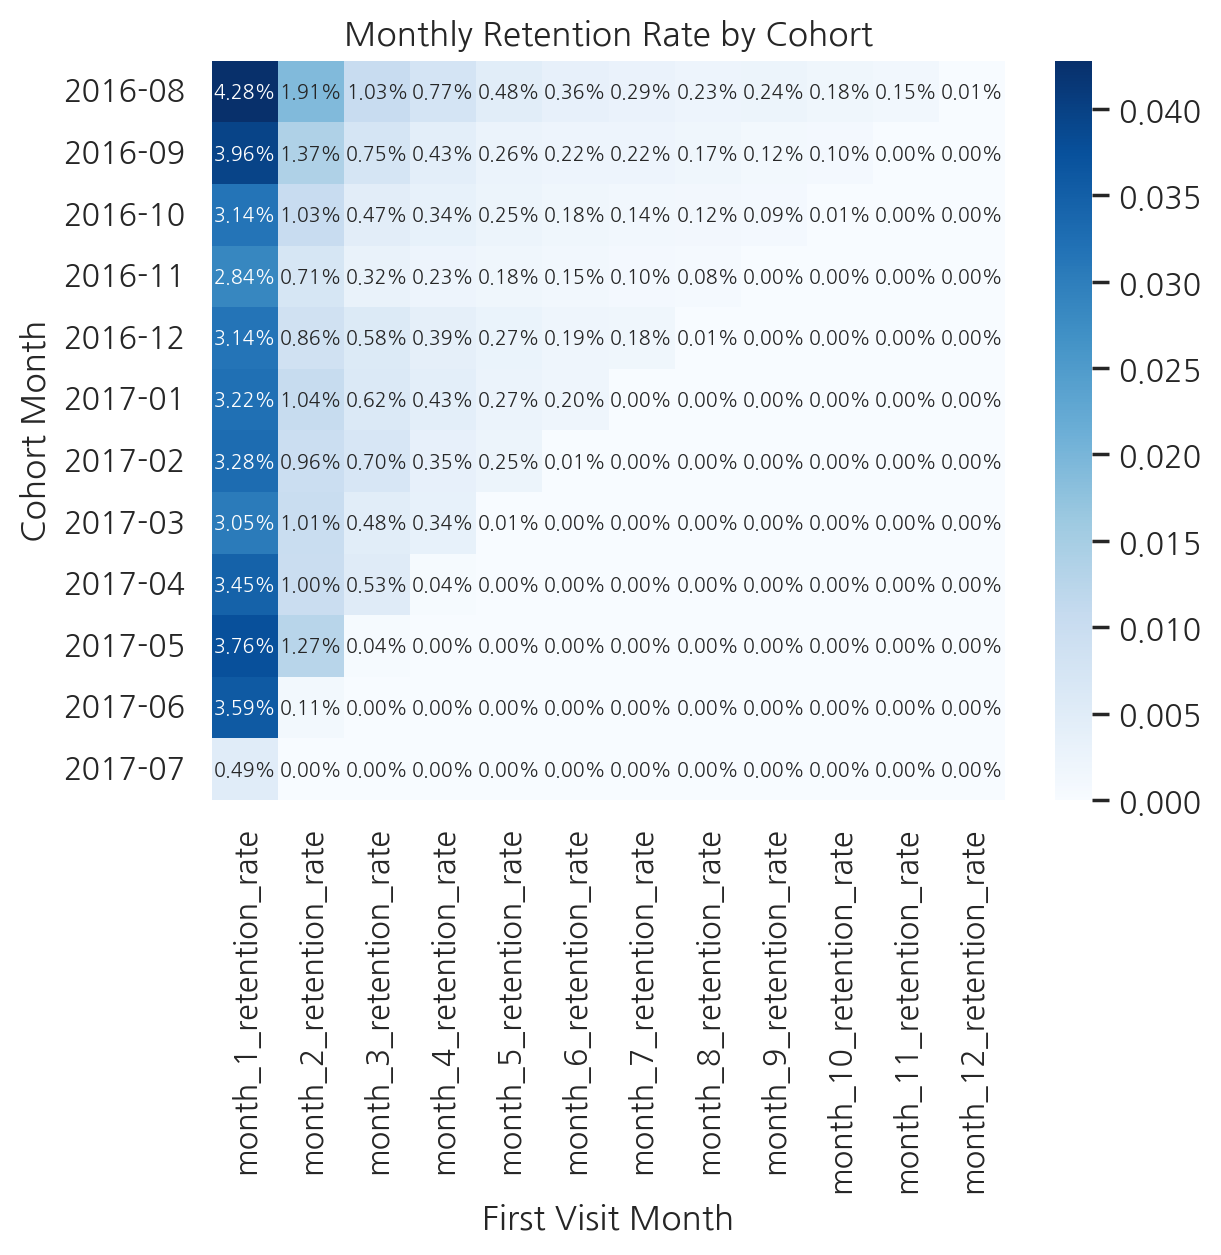

In [ ]:
# 코호트 분석 heatmap 시각화
retention_cols = ['month_1_retention_rate', 'month_2_retention_rate', 'month_3_retention_rate',
                   'month_4_retention_rate', 'month_5_retention_rate', 'month_6_retention_rate',
                   'month_7_retention_rate', 'month_8_retention_rate', 'month_9_retention_rate',
                   'month_10_retention_rate', 'month_11_retention_rate', 'month_12_retention_rate']

retention_data = x[retention_cols]
retention_data.index = x['cohort_month']

sns.heatmap(retention_data, annot = True,annot_kws = {'size' : 7}, fmt = '.2%', cmap = 'Blues')
plt.title('Monthly Retention Rate by Cohort')
plt.xlabel('First Visit Month')
plt.ylabel('Cohort Month')
plt.show()

# ２. visitStartTime 기반 유입 트렌드
- visitStartTime을 사람이 이해할 수 있는 일상 시간대로 변환해 요일*시간대별 방문 패턱을 파악
- dayofweek : 1 = 일요일, 7 = 토요일 / weekday :  0 = 월요일, 6 = 일요일
- GA4에 저장된 빅쿼리 데이터는 일상에서 사용하는 시간이 아닌 값 저장   
  => timestamp_micros 사용하면 일상에서 볼 수 있는 시간대로 값 받음
- visitStartTime : 초 단위 UNIX 타임 스탬프 / timestamp_micros : 마이크로초 단위 UNIX 타임 스탬프   
=> 단위를 맞춰주기 위해 1000000 곱해줌

In [ ]:
query = f"""
SELECT
  EXTRACT(DAYOFWEEK FROM TIMESTAMP_MICROS(visitStartTime * 1000000)) AS day_of_week,
  EXTRACT(HOUR FROM TIMESTAMP_MICROS(visitStartTime * 1000000)) AS hour,
  COUNT(DISTINCT fullVisitorId) AS users
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
GROUP BY 1, 2
ORDER BY day_of_week, hour
"""
result = client.query(query).result().to_dataframe()
display(result.head(20))

,day_of_week,hour,users
0,1,0,3339
1,1,1,3403
2,1,2,3455
3,1,3,3407
4,1,4,3487
5,1,5,3320
6,1,6,3283
7,1,7,3424
8,1,8,3291
9,1,9,3231


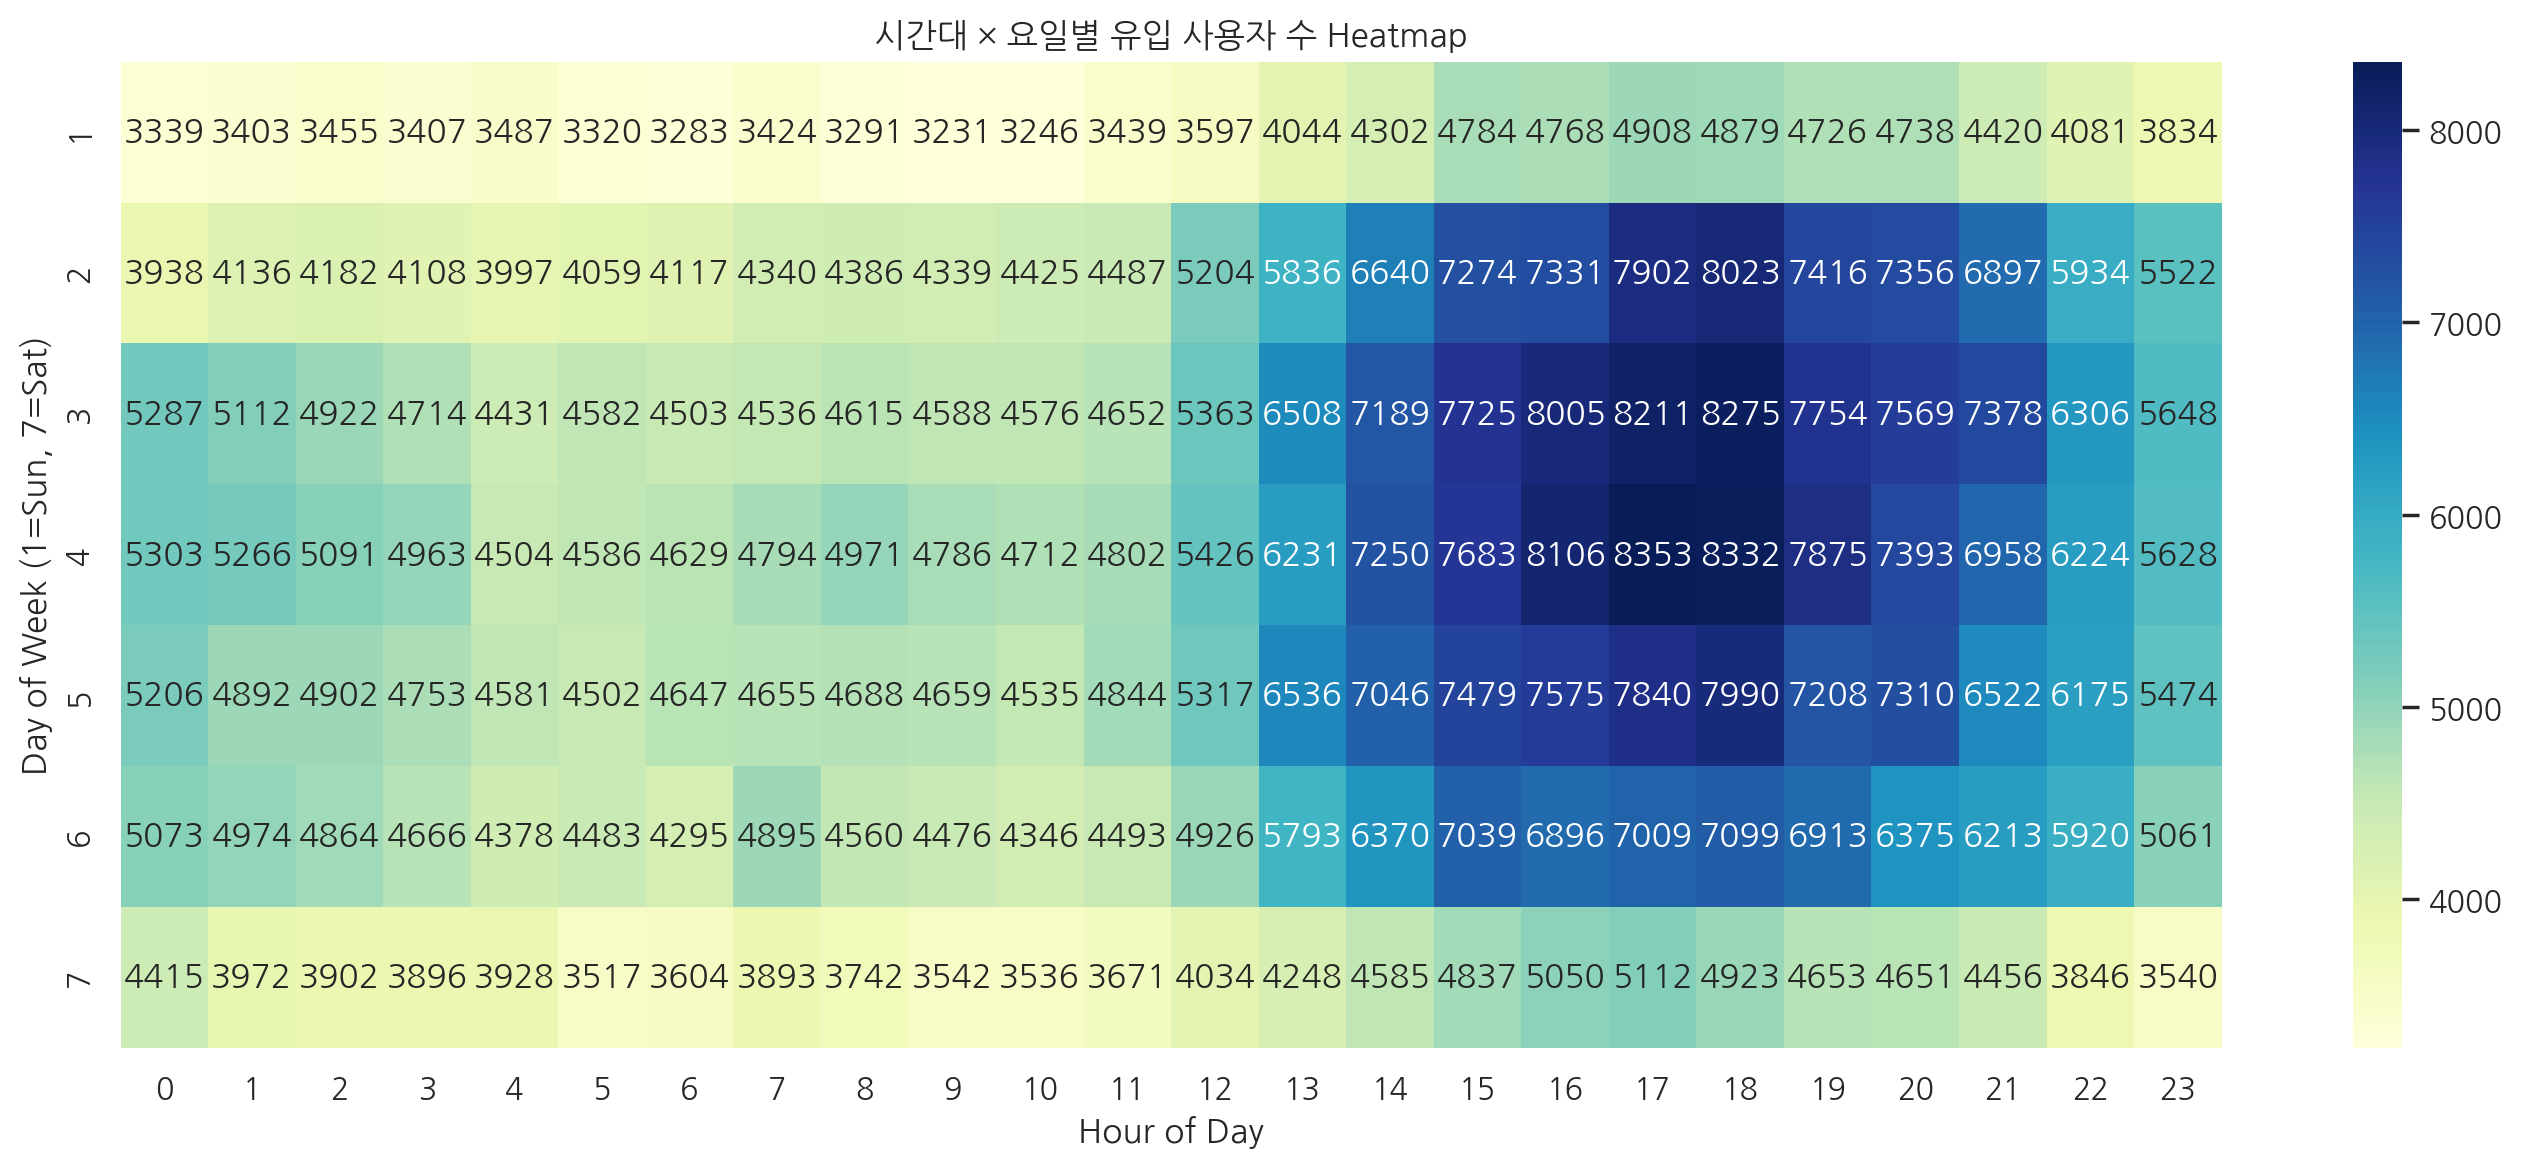

In [ ]:
# 쿼리 결과를 pivot 형태로 변환
pivot_df = result.pivot(index='day_of_week', columns='hour', values='users')
pivot_df = pivot_df.astype(float)

# 시각화
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap="YlGnBu")
plt.title('시간대 × 요일별 유입 사용자 수 Heatmap')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (1=Sun, 7=Sat)')
plt.tight_layout()
plt.show()


# ３. DAU / MAU / Stickiness
- DAU
  - DATE 필드를 기준으로 그룹화
- MAU
  - DATE 필드를 월 단위 문자열로 변환해서 그룹화
- Stickiness
  - dau CTE
  - mau CTE
  - 최종 SELECT
    - dau와 mau를 월 기준으로 조인
    - 각 일자별로 dau / mau 비율을 계산

### ３-1. DAU / MAU

In [ ]:
## DAU
query = f"""
SELECT
  DATE,
  COUNT(DISTINCT fullVisitorId) AS dau
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
GROUP BY DATE
ORDER BY DATE
"""
x = client.query(query).result().to_dataframe()
x

,DATE,dau
0,20160801,1569
1,20160802,1961
2,20160803,2657
3,20160804,2947
4,20160805,2492
...,...,...
361,20170728,2233
362,20170729,1498
363,20170730,1649
364,20170731,2368


In [ ]:
## MAU
query = f"""
SELECT
  FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', date)) AS month,
  COUNT(DISTINCT fullVisitorId) AS mau
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
GROUP BY month
ORDER BY month

"""
x = client.query(query).result().to_dataframe()
x

,month,mau
0,2016-08,61699
1,2016-09,59121
2,2016-10,84901
3,2016-11,99734
4,2016-12,63839
5,2017-01,53041
6,2017-02,51364
7,2017-03,57888
8,2017-04,55681
9,2017-05,52233


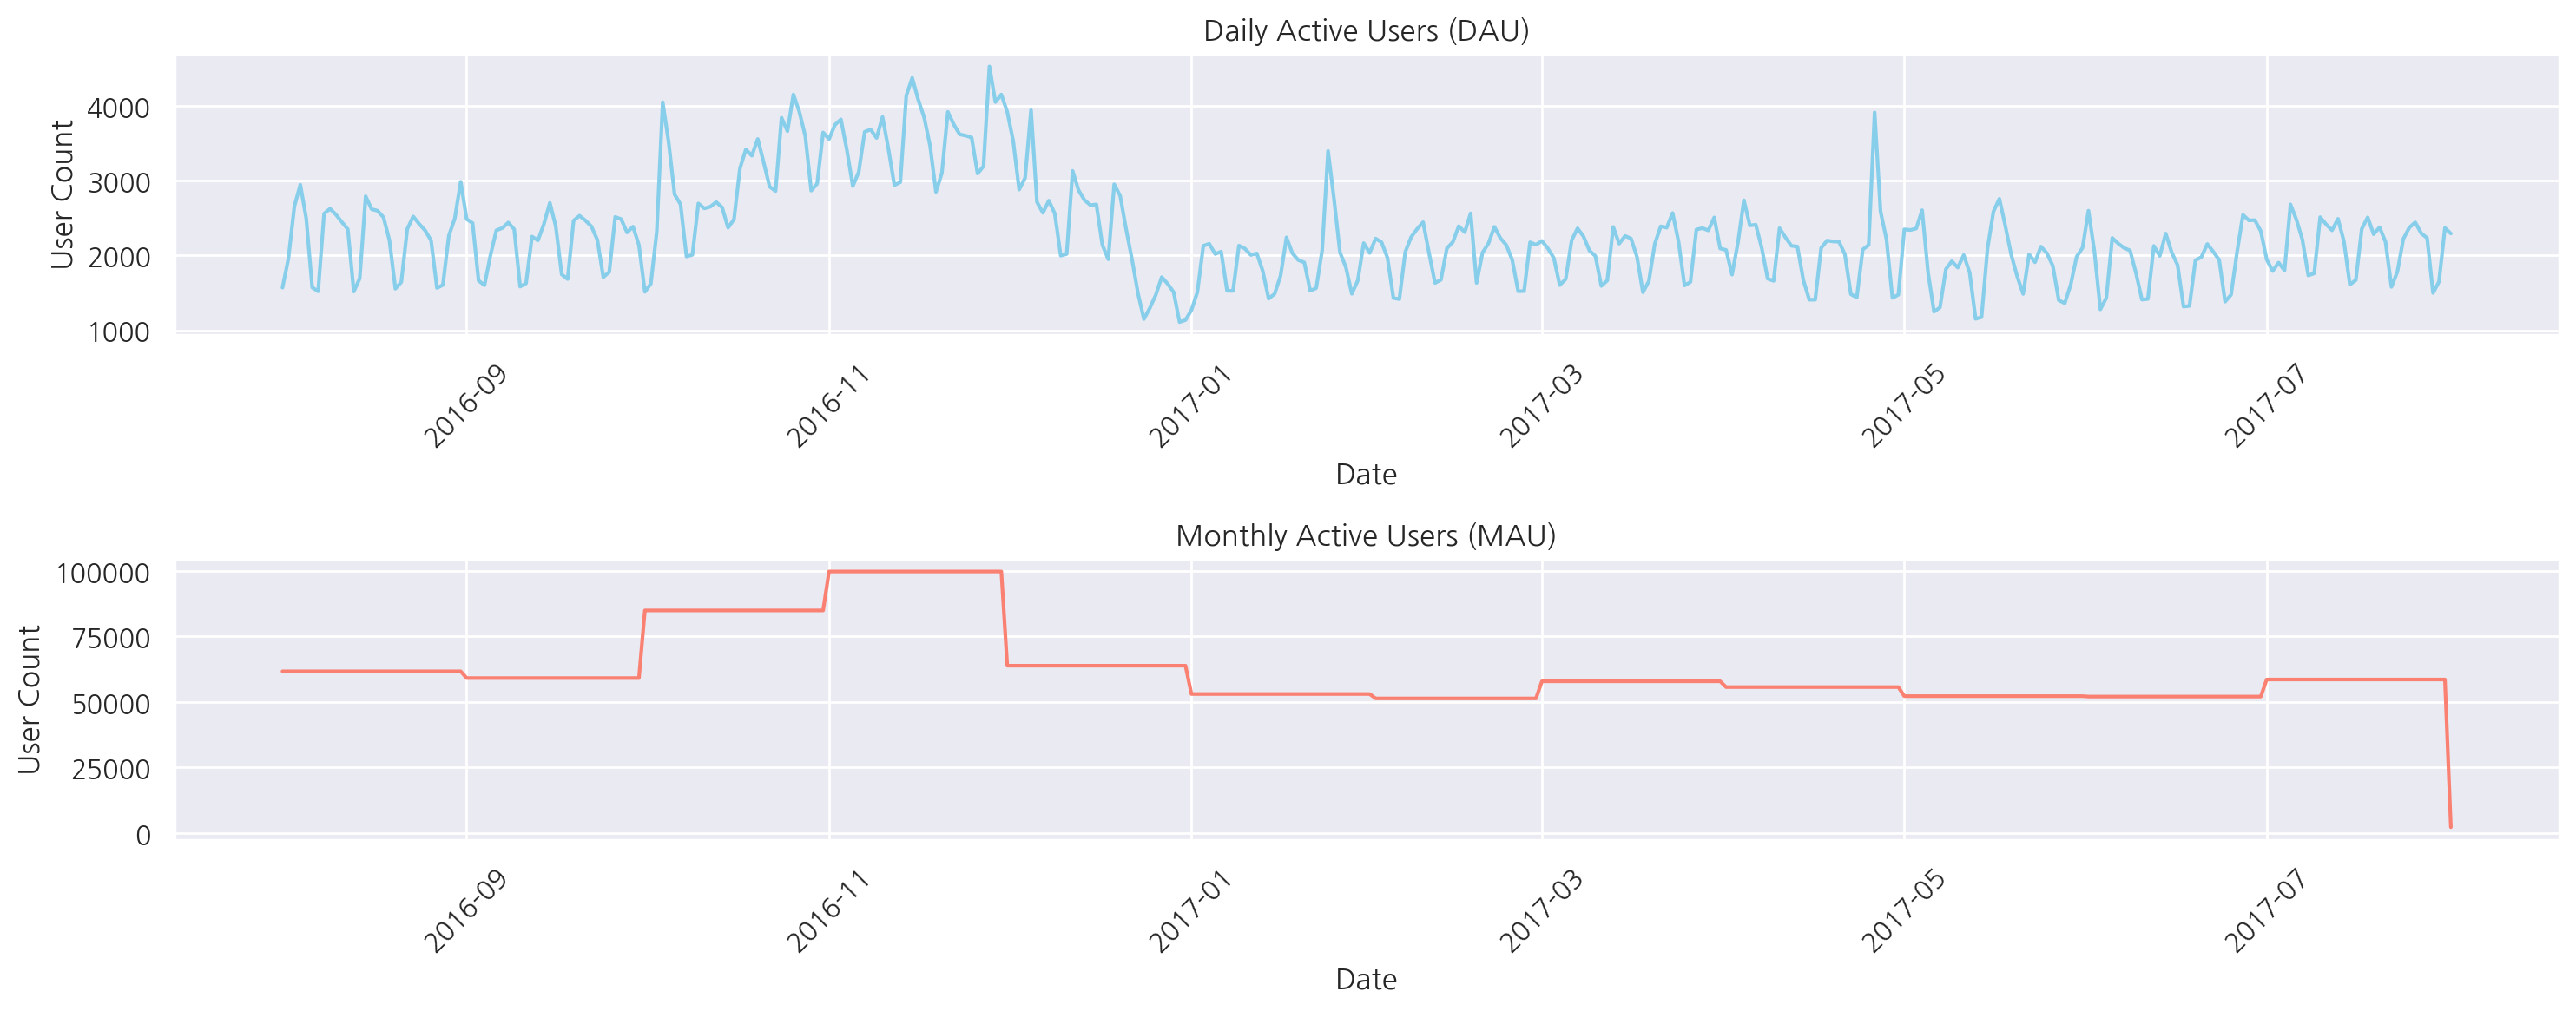

In [ ]:
## DAU랑 MAU도 시각화하기
plt.figure(figsize=(15, 6))

# DAU 그래프
plt.subplot(2, 1, 1)
plt.plot(x['DATE'], x['dau'], label='DAU', color='skyblue')
plt.title('Daily Active Users (DAU)')
plt.xlabel('Date')
plt.ylabel('User Count')
plt.xticks(rotation=45)

# MAU 그래프
plt.subplot(2, 1, 2)
plt.plot(x['DATE'], x['mau'], label='MAU', color='salmon')
plt.title('Monthly Active Users (MAU)')
plt.xlabel('Date')
plt.ylabel('User Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### ３-2. Stickiness

In [ ]:
## DAU/MAU 비율 계산 (Stickiness 지표)
query = f"""
-- DAU와 MAU를 조인해서 비율 계산
WITH dau AS (
  SELECT
    PARSE_DATE('%Y%m%d', date) AS date,
    COUNT(DISTINCT fullVisitorId) AS dau
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  GROUP BY DATE
  ORDER BY DATE
),
mau AS (
  SELECT
    FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', date)) AS month,
    COUNT(DISTINCT fullVisitorId) AS mau
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  GROUP BY month
  ORDER BY month
)
SELECT
  FORMAT_DATE('%Y-%m', d.DATE) AS month,
  d.DATE,
  d.dau,
  m.mau,
  ROUND(d.dau / m.mau, 4) AS dau_mau_ratio
FROM dau d
JOIN mau m ON FORMAT_DATE('%Y-%m', d.DATE) = m.month
ORDER BY d.DATE
"""
x= client.query(query).result().to_dataframe()
x[:-1]

,month,DATE,dau,mau,dau_mau_ratio
0,2016-08,2016-08-01,1569,61699,0.0254
1,2016-08,2016-08-02,1961,61699,0.0318
2,2016-08,2016-08-03,2657,61699,0.0431
3,2016-08,2016-08-04,2947,61699,0.0478
4,2016-08,2016-08-05,2492,61699,0.0404
...,...,...,...,...,...
360,2017-07,2017-07-27,2297,58569,0.0392
361,2017-07,2017-07-28,2233,58569,0.0381
362,2017-07,2017-07-29,1498,58569,0.0256
363,2017-07,2017-07-30,1649,58569,0.0282


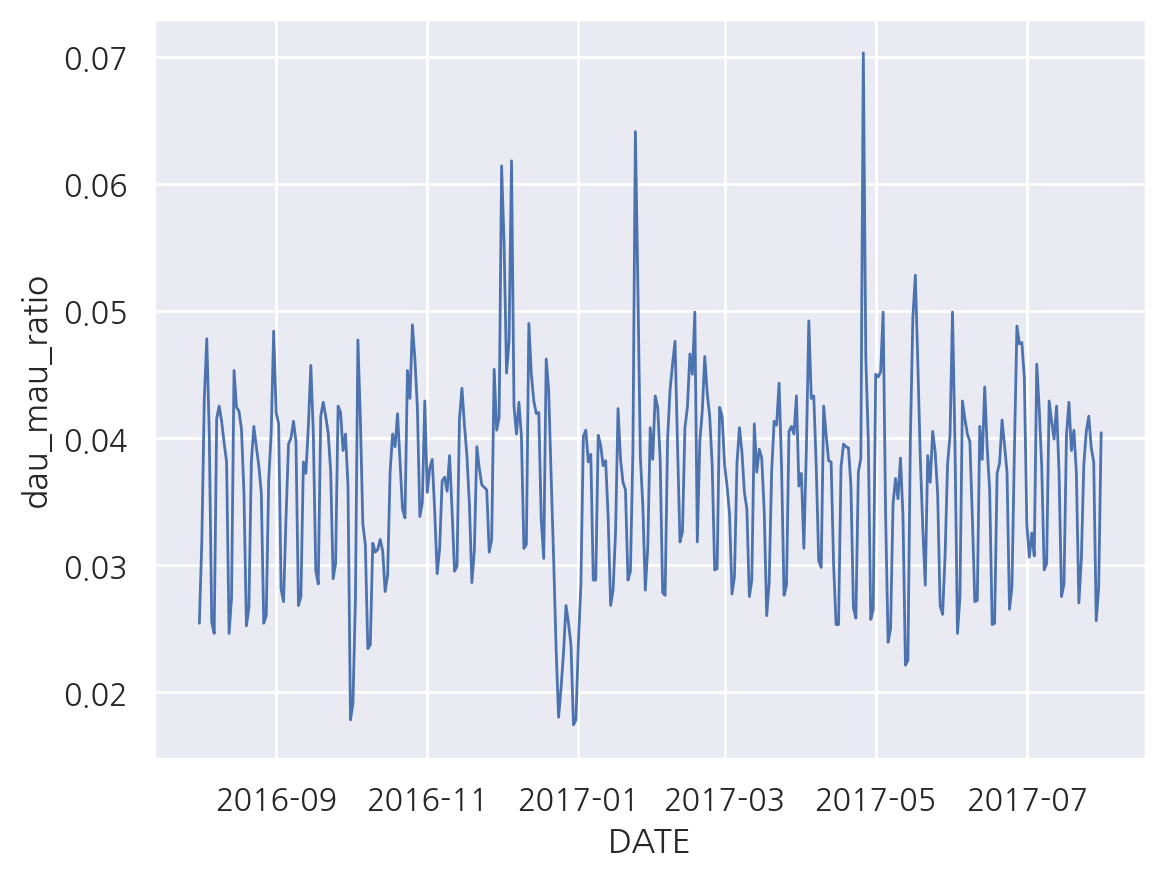

In [ ]:
sns.lineplot(data = x[:-1], x= 'DATE', y = 'dau_mau_ratio', linewidth = 1)
plt.show()

# ４. Classic Retention (N일 후 재방문율)
- 사용자가 첫 방문일 이후 정확히 N일째에 다시 방문한 비율을 측정해 단기 재방문 충성도를 평가
- first_visits CTE
  - 유저별 첫 방문 날짜 추출
- day_n_visits CTE
  - 전체 방문 이력 추출
- classic_retention CTE
  - 기준일로부터 3일 후 정확히 재방문한 유저 집계
- 최종 SELECT
  - 리텐션율 계산 및 결과 출력

In [ ]:
query = f"""
WITH first_visits AS (
  SELECT
    fullVisitorId AS user_pseudo_id,  -- UA에서 사용자를 식별하는 고유 ID
    DATE(MIN(PARSE_TIMESTAMP('%Y%m%d', date))) AS first_visit_date  -- 최초 방문일을 date 문자열을 TIMESTAMP로 파싱 후 DATE로 변환
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`  -- UA 세션 데이터 사용
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'  -- 분석 대상 날짜 범위 지정
  GROUP BY
    fullVisitorId
),

day_n_visits AS (
  SELECT
    fullVisitorId AS user_pseudo_id,  -- 동일하게 사용자 ID 사용
    DATE(PARSE_TIMESTAMP('%Y%m%d', date)) AS visit_date  -- 방문일을 date 문자열에서 DATE 타입으로 변환
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`  -- 동일한 데이터셋 사용
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'  -- 동일한 날짜 범위
),

classic_retention AS (
  SELECT
    fv.first_visit_date,  -- 최초 방문일 기준으로 그룹화
    COUNT(DISTINCT fv.user_pseudo_id) AS d0_users,  -- 기준일(D0)에 방문한 전체 사용자 수
    COUNT(DISTINCT CASE
      WHEN dv.visit_date = DATE_ADD(fv.first_visit_date, INTERVAL 3 DAY)  -- 기준일 + 3일에 방문한 사용자만 카운트
      THEN dv.user_pseudo_id END) AS day3_retained  -- 3일차 유지된 사용자 수
  FROM
    first_visits fv
  LEFT JOIN
    day_n_visits dv
  ON
    fv.user_pseudo_id = dv.user_pseudo_id  -- 사용자 기준으로 조인
  GROUP BY
    fv.first_visit_date  -- 각 최초 방문일별로 집계
)

SELECT
  first_visit_date,  -- 최초 방문일
  d0_users,  -- 기준일 유저 수
  day3_retained,  -- 3일 후에 재방문한 유저 수
  SAFE_DIVIDE(day3_retained, d0_users) AS day3_retention_rate  -- 리텐션율 = 재방문 유저 / 전체 유저
FROM
  classic_retention
ORDER BY
  first_visit_date
"""
result = client.query(query).result().to_dataframe()
display(result.head(50))

,first_visit_date,d0_users,day3_retained,day3_retention_rate
0,2016-08-01,1569,41,0.026131
1,2016-08-02,1884,39,0.020701
2,2016-08-03,2502,10,0.003997
3,2016-08-04,2771,16,0.005774
4,2016-08-05,2295,38,0.016558
5,2016-08-06,1479,13,0.008790
6,2016-08-07,1423,13,0.009136
7,2016-08-08,2307,34,0.014738
8,2016-08-09,2364,19,0.008037
9,2016-08-10,2265,7,0.003091


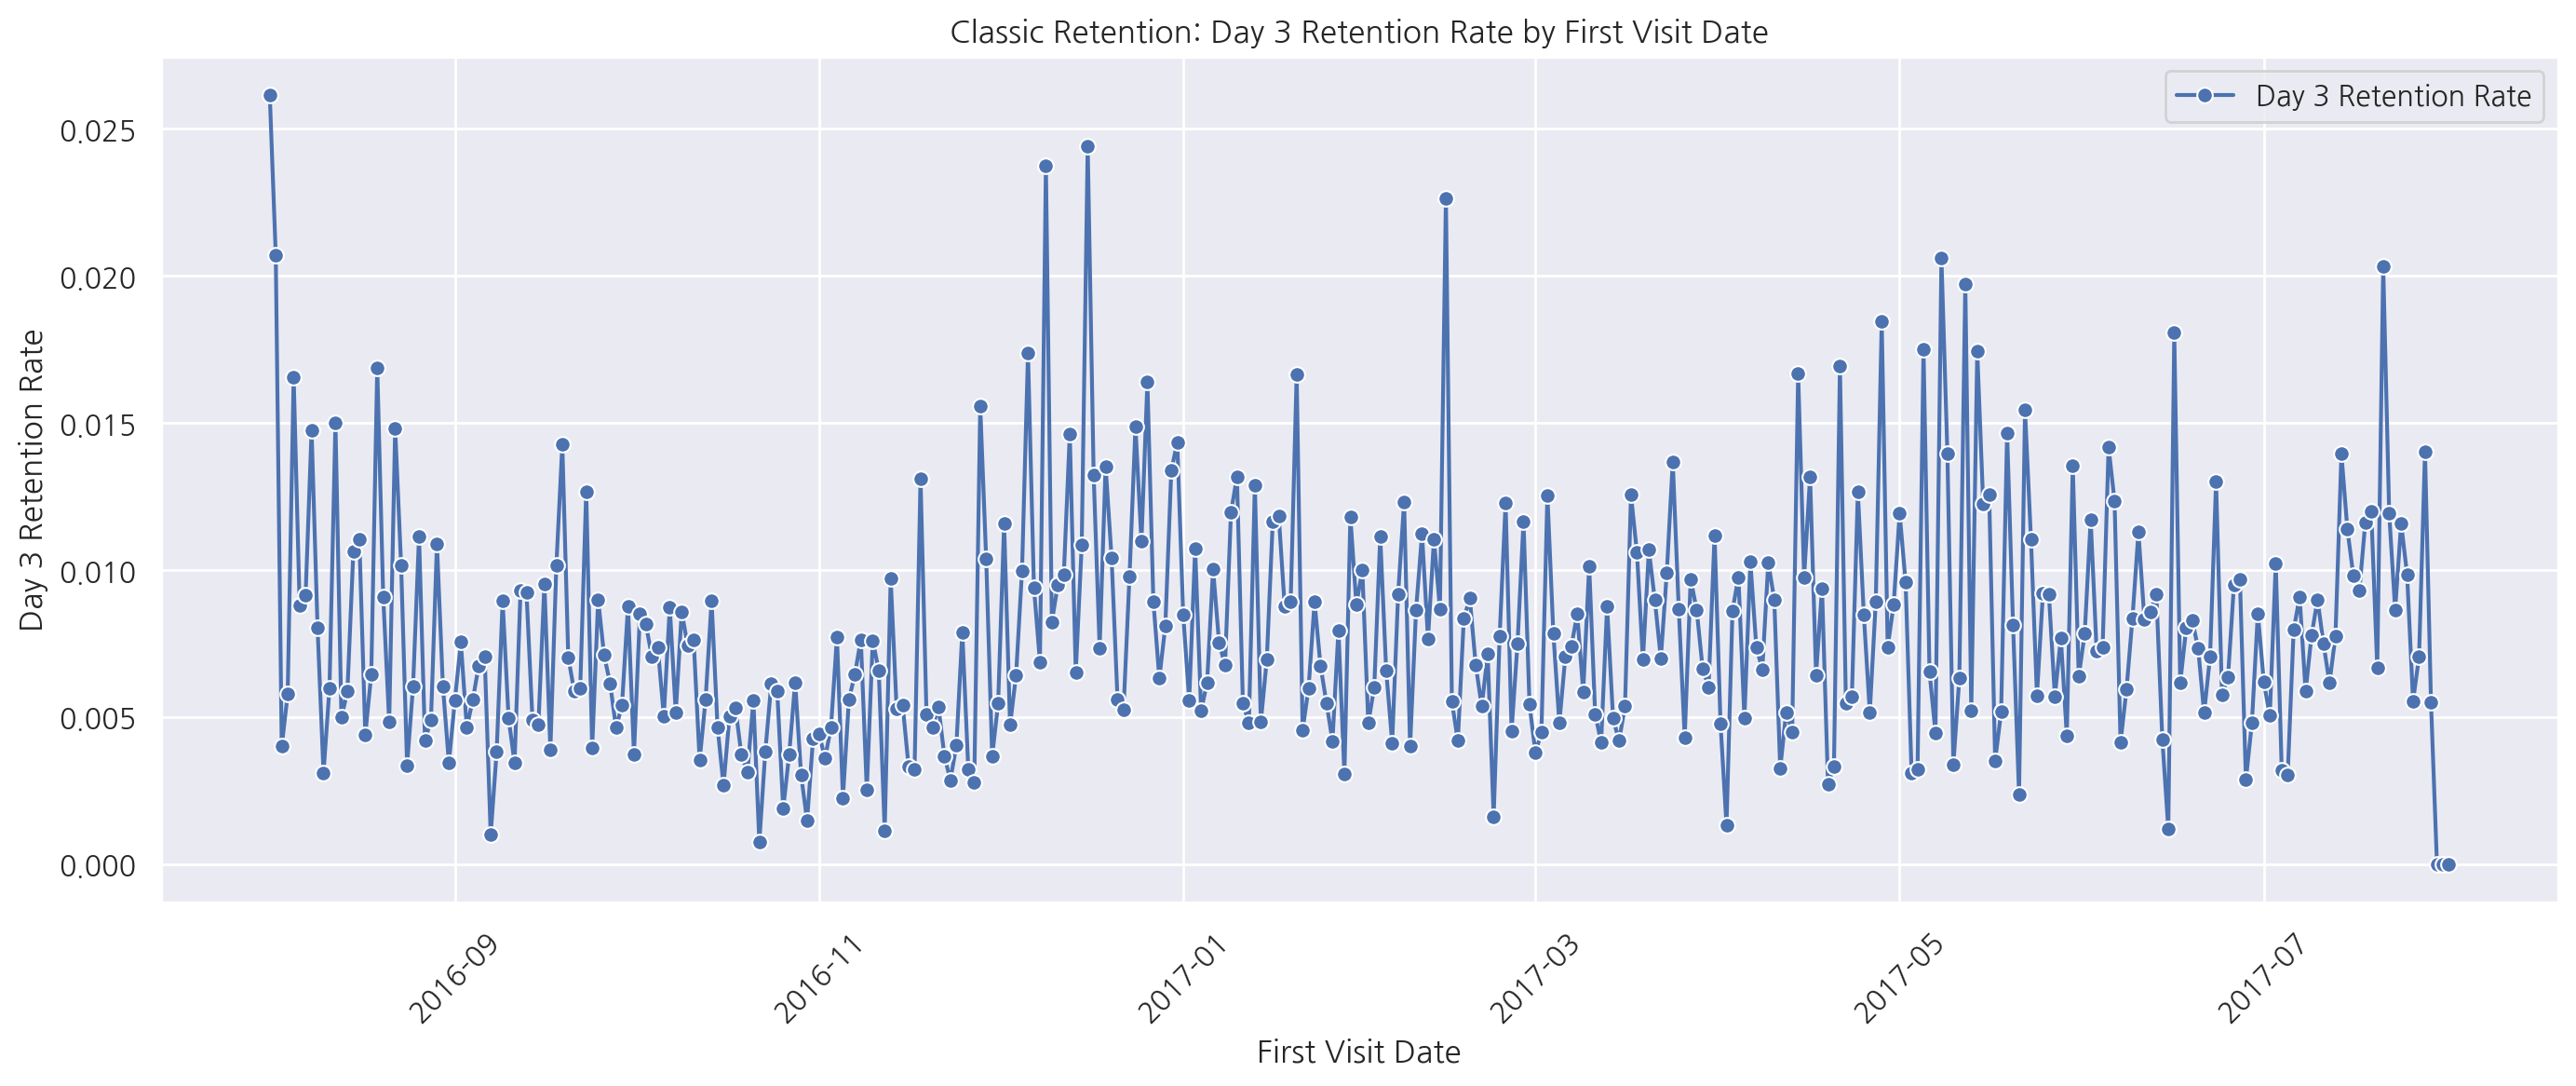

In [ ]:
# 날짜형으로 변환 (혹시 안 되어 있다면)
result['first_visit_date'] = pd.to_datetime(result['first_visit_date'])

# 그래프 설정
plt.figure(figsize=(14, 6))
sns.lineplot(data=result, x='first_visit_date', y='day3_retention_rate', marker='o', label='Day 3 Retention Rate')

# 세부 설정
plt.title('Classic Retention: Day 3 Retention Rate by First Visit Date')
plt.xlabel('First Visit Date')
plt.ylabel('Day 3 Retention Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ５. 요일별 Retention
- 첫 방문 요일을 기준으로 N일 후 재방문 비율을 요일별로 비교해, 어떤 요일 유입이 더 높은 유지율을 보이는지 평가
- first_visits CTE
  - 유저별 첫 방문 날짜 추출
- day_n_visits CTE
  - 전체 방문 이력 추출
- classic_retention CTE
  - 기준일로부터 3일 후 정확히 재방문한 유저 집계
- 최종 SELECT
  - 요일별 리텐션 계산 및 결과 출력

In [ ]:
query = f"""
WITH first_visits AS (
  SELECT
    fullVisitorId AS user_pseudo_id,  -- UA에서 사용자를 식별하는 고유 ID
    DATE(MIN(PARSE_TIMESTAMP('%Y%m%d', date))) AS first_visit_date  -- 최초 방문일을 date 문자열을 TIMESTAMP로 파싱 후 DATE로 변환
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`  -- UA 세션 데이터 사용
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'  -- 분석 대상 날짜 범위 지정
  GROUP BY
    fullVisitorId
),

day_n_visits AS (
  SELECT
    fullVisitorId AS user_pseudo_id,  -- 동일하게 사용자 ID 사용
    DATE(PARSE_TIMESTAMP('%Y%m%d', date)) AS visit_date  -- 방문일을 date 문자열에서 DATE 타입으로 변환
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`  -- 동일한 데이터셋 사용
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'  -- 동일한 날짜 범위
),

classic_retention AS (
  SELECT
    fv.first_visit_date,  -- 최초 방문일 기준으로 그룹화
    COUNT(DISTINCT fv.user_pseudo_id) AS d0_users,  -- 기준일(D0)에 방문한 전체 사용자 수
    COUNT(DISTINCT CASE
      WHEN dv.visit_date = DATE_ADD(fv.first_visit_date, INTERVAL 3 DAY)  -- 기준일 + 3일에 방문한 사용자만 카운트
      THEN dv.user_pseudo_id END) AS day3_retained  -- 3일차 유지된 사용자 수
  FROM
    first_visits fv
  LEFT JOIN
    day_n_visits dv
  ON
    fv.user_pseudo_id = dv.user_pseudo_id  -- 사용자 기준으로 조인
  GROUP BY
    fv.first_visit_date  -- 각 최초 방문일별로 집계
)

SELECT
  FORMAT_TIMESTAMP('%A', TIMESTAMP(first_visit_date)) AS day_of_week,
  AVG(SAFE_DIVIDE(day3_retained, d0_users)) AS avg_day3_retention_rate,
  COUNT(*) AS num_days_sampled
FROM
  classic_retention
GROUP BY
  day_of_week
ORDER BY
  avg_day3_retention_rate DESC;
"""
result = client.query(query).result().to_dataframe()
display(result)

,day_of_week,avg_day3_retention_rate,num_days_sampled
0,Friday,0.012352,52
1,Monday,0.009952,53
2,Tuesday,0.009168,53
3,Sunday,0.006861,52
4,Saturday,0.006527,52
5,Thursday,0.006010,52
6,Wednesday,0.004784,52


/tmp/ipython-input-522051633.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




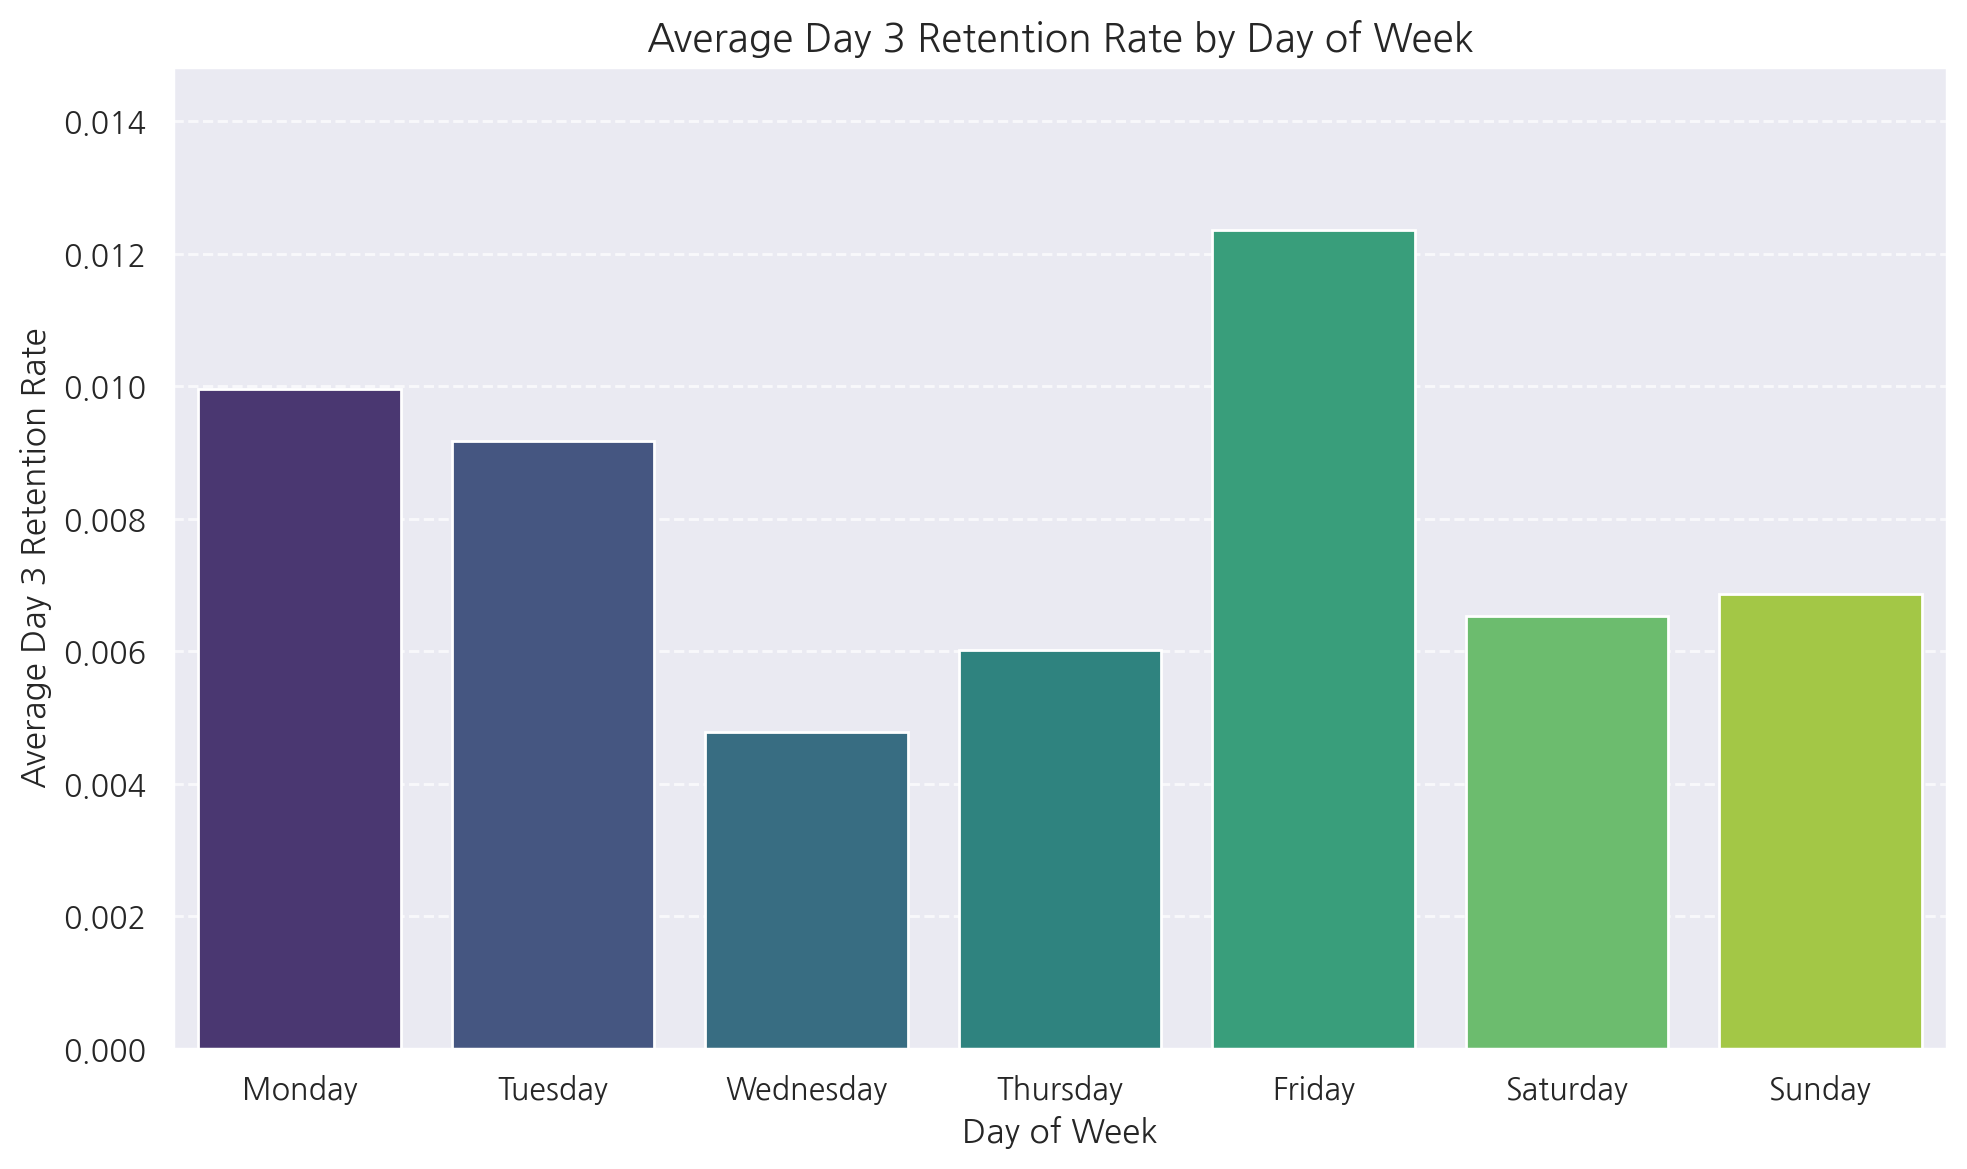

In [ ]:
# 요일 순서 정렬용 리스트 (월~일)
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
result['day_of_week'] = pd.Categorical(result['day_of_week'], categories=ordered_days, ordered=True)
result = result.sort_values('day_of_week')

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(
    x='day_of_week',
    y='avg_day3_retention_rate',
    data=result,
    palette='viridis'
)

plt.title('Average Day 3 Retention Rate by Day of Week', fontsize=14)
plt.xlabel('Day of Week')
plt.ylabel('Average Day 3 Retention Rate')
plt.ylim(0, result['avg_day3_retention_rate'].max() * 1.2)  # 약간 여유 있게 y축 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# ６. Long Retention (30~60일 내 재방문)
- 첫 방문 후 30~60일 사이에 재방문한 사용자 비율로 장기 유지력을 산출해 그룹별로 비교
- first_visits CTE
  - 유저별 첫 방문일 계산 (D0)
- all_visits CTE
  - 전체 방문 이력
- rolling_flags CTE
  - Rolling 7일 리텐션 여부
- long_flag CTE
  - Long-term (D30~60) 리텐션 여부
- combined_flags CTE
  - 두 리텐션 플래그 결합
- 최종 SELECT
  - 그룹별 long-term 리텐션 비율 비교

In [ ]:
query = f"""
WITH first_visits AS (
  SELECT
    fullVisitorId AS user_id,
    DATE(MIN(PARSE_TIMESTAMP('%Y%m%d', date))) AS first_visit_date
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  GROUP BY
    fullVisitorId
),

all_visits AS (
  SELECT
    fullVisitorId AS user_id,
    DATE(PARSE_TIMESTAMP('%Y%m%d', date)) AS visit_date
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
),

rolling_flags AS (
  SELECT
    fv.user_id,
    MAX(CASE
      WHEN av.visit_date BETWEEN DATE_ADD(fv.first_visit_date, INTERVAL 1 DAY)
                            AND DATE_ADD(fv.first_visit_date, INTERVAL 7 DAY)
      THEN 1 ELSE 0 END) AS rolling_retained_7d
  FROM
    first_visits fv
  LEFT JOIN
    all_visits av
  ON
    fv.user_id = av.user_id
  GROUP BY
    fv.user_id
),

long_flags AS (
  SELECT
    fv.user_id,
    MAX(CASE
      WHEN av.visit_date BETWEEN DATE_ADD(fv.first_visit_date, INTERVAL 30 DAY)
                            AND DATE_ADD(fv.first_visit_date, INTERVAL 60 DAY)
      THEN 1 ELSE 0 END) AS long_retained_30d
  FROM
    first_visits fv
  LEFT JOIN
    all_visits av
  ON
    fv.user_id = av.user_id
  GROUP BY
    fv.user_id
),

combined_flags AS (
  SELECT
    r.user_id,
    r.rolling_retained_7d,
    l.long_retained_30d
  FROM
    rolling_flags r
  JOIN
    long_flags l
  ON
    r.user_id = l.user_id
)

-- [6] 그룹별 long-term 리텐션 비율 비교
SELECT
  rolling_retained_7d,  -- 7일 내 재방문 여부 그룹 (0 or 1)
  COUNT(*) AS total_users,
  SUM(long_retained_30d) AS long_retained_users,
  SAFE_DIVIDE(SUM(long_retained_30d), COUNT(*)) AS long_retention_rate
FROM
  combined_flags
GROUP BY
  rolling_retained_7d
ORDER BY
  rolling_retained_7d DESC;
"""
result = client.query(query).result().to_dataframe()
display(result.head(50))

,rolling_retained_7d,total_users,long_retained_users,long_retention_rate
0,1,38456,2802,0.072862
1,0,675711,7939,0.011749
